## Shelter Animal Outcomes
### MIDS W207 Final Project
### Clay Miller, Roseanna Hopper, Yubo Zhang

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import FeatureHasher, DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from bokeh.charts import Bar, output_file, show, output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [89]:
# Load the data
data = pd.read_csv('../data/train.csv')
breeds = pd.read_csv('../data/breeds.csv')
breeds['Breed'] = breeds['Breed'].str.strip()
top_breed_list = []
for b in breeds['Breed']:
    top_breed_list.append(b.strip())
data['OutcomeSubtype'] = data['OutcomeSubtype'].fillna('')
data['Female'] = 'Female' in data['SexuponOutcome']
data['AgeuponOutcome'].fillna('', inplace = True)

def ageConvert(age):
    regexyear = '(\d+) year'
    regexmnth = '(\d+) month'
    regexwk = '(\d+) week'
    regexday = '(\d+) day'
    if re.match(regexyear, age):
        const = int(re.match(regexyear, age).groups()[0])
        return const*52
    elif re.match(regexmnth, age):
        const = int(re.match(regexmnth, age).groups()[0])
        return const*4.5 # a month is roughly 4.5 weeks
    elif re.match(regexwk, age):
        return int(re.match(regexwk, age).groups()[0])
    elif re.match(regexday, age):
        const = int(re.match(regexday, age).groups()[0])
        return const/7 #7 days in a week
    else:
        return None
    
data['ConvertedAge']=data['AgeuponOutcome'].apply(ageConvert)


def female(i):
    i = str(i)
    if i.find('Female') >= 0: return 'Female'
    if i.find('Unknown') >= 0: return 'Unknown'
    return 'Male'
data['Female'] = data.SexuponOutcome.apply(female)

def intact(i):
    i = str(i)
    if i.find('Intact') >= 0: return 'Intact'
    if i.find('Unknown') >= 0: return 'Unknown'
    return 'Spayed/Neutered'
data['Intact'] = data.SexuponOutcome.apply(intact)

def mixed_breed(i):
    i = str(i)
    if i.find('Mix') >= 0: return 'Mixed Breed'
    if i.find('/') >= 0: return 'Known Breed Combo'
    return 'Nonmixed'
data['MixedBreed'] = data.Breed.apply(mixed_breed)

def top_breed(i):
    i = str(i)
    if any(word in i for word in top_breed_list):
        return int(1)
    else:
        return int(0)
data['TopBreed'] = data.Breed.apply(top_breed)

def breed_rank(i):
    i = str(i)
    ranks = []
    for word in top_breed_list:
        if word in i:
            ranks.append(int(breeds.loc[breeds['Breed'] == word]['2007']))
    if len(ranks) > 0:
        return np.mean(ranks)
    else:
        return 51.0
data['BreedRank'] = data.Breed.apply(breed_rank)

def naming(i):
    if pd.isnull(i): return 'Unnamed'
    return 'Named'
data['Named'] = data.Name.apply(naming)

#Change all breed and color strings so that they are ordered consistently
#E.G. all "brown/black" and "black/brown" should become "black, brown"
def reorder(i):
    i = str(i)
    if i.find(" ") >= 0: i = i.replace(" ", "-")
    if i.find("/") >= 0: i = i.replace("/", " ")
    i = i.split()
    i = sorted(i)
    i = ' '.join(i)
    return i

data['OrderedColor'] = data.Color.apply(reorder)
data['OrderedBreed'] = data.Breed.apply(reorder)


In [90]:
data.head(10)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Female,ConvertedAge,Intact,MixedBreed,TopBreed,BreedRank,Named,OrderedColor,OrderedBreed
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,Male,52.0,Spayed/Neutered,Mixed Breed,1,20.0,Named,Brown White,Shetland-Sheepdog-Mix
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,Female,52.0,Spayed/Neutered,Mixed Breed,0,51.0,Named,Cream-Tabby,Domestic-Shorthair-Mix
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,Male,104.0,Spayed/Neutered,Mixed Breed,0,51.0,Named,Blue White,Pit-Bull-Mix
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,Male,3.0,Intact,Mixed Breed,0,51.0,Unnamed,Blue-Cream,Domestic-Shorthair-Mix
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,Male,104.0,Spayed/Neutered,Known Breed Combo,1,28.5,Unnamed,Tan,Lhasa-Apso Miniature-Poodle
5,A677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,Dog,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan,Female,4.5,Intact,Known Breed Combo,1,30.0,Named,Black Tan,Cairn-Terrier Chihuahua-Shorthair
6,A699218,Jimmy,2015-03-28 13:11:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Tabby,Male,3.0,Intact,Mixed Breed,0,51.0,Named,Blue-Tabby,Domestic-Shorthair-Mix
7,A701489,NaN,2015-04-30 17:02:00,Transfer,Partner,Cat,Unknown,3 weeks,Domestic Shorthair Mix,Brown Tabby,Unknown,3.0,Unknown,Mixed Breed,0,51.0,Unnamed,Brown-Tabby,Domestic-Shorthair-Mix
8,A671784,Lucy,2014-02-04 17:17:00,Adoption,,Dog,Spayed Female,5 months,American Pit Bull Terrier Mix,Red/White,Female,22.5,Spayed/Neutered,Mixed Breed,0,51.0,Named,Red White,American-Pit-Bull-Terrier-Mix
9,A677747,NaN,2014-05-03 07:48:00,Adoption,Offsite,Dog,Spayed Female,1 year,Cairn Terrier,White,Female,52.0,Spayed/Neutered,Nonmixed,1,48.0,Unnamed,White,Cairn-Terrier


In [91]:
#Remove unnecessary variables
#del data['AnimalID']
#del data['Name']
#del data['DateTime']
#del data['Breed']
#del data['OutcomeSubtype']
#del data['SexuponOutcome']
#del data['AgeuponOutcome']
#del data['Color']
#del data['OrderedBreed']
#del data['OrderedColor']

continuous = ['ConvertedAge','BreedRank']
discrete = [
    'AnimalType',
    'Female',
    'Intact',
    'MixedBreed',
    'Named',
    'TopBreed'
]
predictors = continuous + discrete
target = 'OutcomeType'

print data.ConvertedAge.unique()

#For those missing an age, fill with the median age by animal type
data["ConvertedAge"] = data.groupby("AnimalType").transform(lambda x: x.fillna(x.median()))
data[continuous].describe().T


[  5.20000000e+01   1.04000000e+02   3.00000000e+00   4.50000000e+00
   2.25000000e+01   2.08000000e+02   1.35000000e+01   2.00000000e+00
   9.00000000e+00   4.50000000e+01   2.70000000e+01   2.60000000e+02
   3.64000000e+02   1.56000000e+02   1.80000000e+01   6.24000000e+02
   4.68000000e+02   3.12000000e+02   1.00000000e+00   5.72000000e+02
   4.00000000e+00   3.15000000e+01   4.16000000e+02   4.95000000e+01
   0.00000000e+00   4.05000000e+01   3.60000000e+01   7.80000000e+02
   5.20000000e+02   7.28000000e+02   5.00000000e+00   8.32000000e+02
   6.76000000e+02              nan   8.84000000e+02   9.36000000e+02
   9.88000000e+02   1.04000000e+03]


,count,mean,std,min,25%,50%,75%,max
ConvertedAge,26729.0,113.370253,154.064766,0.0,9.0,52.0,156.0,1040.0
BreedRank,26729.0,35.975981,20.246237,1.0,12.0,51.0,51.0,51.0


In [121]:
data_dog = data[data['AnimalType'] == 'Dog']
data_dog.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Female,ConvertedAge,Intact,MixedBreed,TopBreed,BreedRank,Named,OrderedColor,OrderedBreed
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,Male,52.0,Spayed/Neutered,Mixed Breed,1,20.0,Named,Brown White,Shetland-Sheepdog-Mix
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,Male,104.0,Spayed/Neutered,Mixed Breed,0,51.0,Named,Blue White,Pit-Bull-Mix
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,Male,104.0,Spayed/Neutered,Known Breed Combo,1,28.5,Unnamed,Tan,Lhasa-Apso Miniature-Poodle
5,A677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,Dog,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan,Female,4.5,Intact,Known Breed Combo,1,30.0,Named,Black Tan,Cairn-Terrier Chihuahua-Shorthair
8,A671784,Lucy,2014-02-04 17:17:00,Adoption,,Dog,Spayed Female,5 months,American Pit Bull Terrier Mix,Red/White,Female,22.5,Spayed/Neutered,Mixed Breed,0,51.0,Named,Red White,American-Pit-Bull-Terrier-Mix


In [125]:
# Train/test split
data_dog = data[data['AnimalType'] == 'Dog']
data_cat = data[data['AnimalType'] == 'Cat']
X = data_cat[predictors]
y = data_cat[[target]]
X_train, X_dev, y_train, y_dev = train_test_split(X, y, random_state=2)

#ss = StandardScaler()
#ss.fit(X_train.loc[:,continuous])
#X_train.loc[:,continuous] = ss.transform(X_train.loc[:,continuous])
#X_dev.loc[:,continuous] = ss.transform(X_dev.loc[:,continuous])

#X_train[continuous].describe().T

In [93]:
class MyVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, cols, hashing=None):
        """
        args:
            cols: a list of column names of the categorical variables
            hashing: 
                If None, then vectorization is a simple one-hot-encoding.
                If an integer, then hashing is the number of features in the output.
        """
        self.cols = cols
        self.hashing = hashing
        
    def fit(self, X, y=None):

        data = X[self.cols]
        
        # Choose a vectorizer
        if self.hashing is None:
            self.myvec = DictVectorizer(sparse=False)
        else:
            self.myvec = FeatureHasher(n_features = self.hashing)
    
        self.myvec.fit(X[self.cols].to_dict(orient='records'))
        return self
            
    def transform(self, X):
            
        # Vectorize Input
        if self.hashing is None:
            return pd.DataFrame(
                self.myvec.transform(X[self.cols].to_dict(orient='records')),
                columns = self.myvec.feature_names_
            )
        else:
            return pd.DataFrame(
                self.myvec.transform(X[self.cols].to_dict(orient='records')).toarray()
            )

In [94]:
#Discrete test

discrete_pipe = Pipeline(steps=[('Vectorizer', MyVectorizer(cols=discrete, hashing=None))])

#### Continous Variables

In [95]:
class MyScaler():
    
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        self.ss = StandardScaler()
        self.ss.fit(X[self.cols])
        return self
    
    def transform(self, X):
        return self.ss.transform(X[self.cols])

In [96]:
#Continuous test
ss = MyScaler(continuous)
transformed_train = ss.fit(X_train)
transformed_dev = ss.transform(X_dev)

In [97]:
continuous_pipe = Pipeline(steps=[('Scale', MyScaler(continuous))])

transformed_train = continuous_pipe.fit(X_train)
transformed_dev = continuous_pipe.transform(X_dev)

#### Feature Union

In [98]:
discrete_pipe = Pipeline(steps=[('Vectorizer', MyVectorizer(cols=discrete, hashing=None))])

continuous_pipe = Pipeline(steps=[('Scale', MyScaler(continuous))])

union = FeatureUnion([('Discrete', discrete_pipe), ('Continuous', continuous_pipe)])

transformed_train = union.fit_transform(X_train)
transformed_dev = union.transform(X_dev)

In [99]:
pipeline = Pipeline([('Preprocess', FeatureUnion([('Discrete', discrete_pipe), ('Continuous', continuous_pipe)])),
                      ('Predict', LogisticRegression(multi_class='multinomial', solver='newton-cg'))])

test_lr = pipeline.fit(X_train, y_train)

C:\Users\Clay\Anaconda2\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [126]:
print "Multinomial Logistic Regression Train Accuracy :: ", metrics.accuracy_score(y_train, test_lr.predict(X_train))
print "Multinomial Logistic Regression Dev Accuracy :: ", metrics.accuracy_score(y_dev, test_lr.predict(X_dev))
 

Multinomial Logistic Regression Train Accuracy ::  0.733053892216
Multinomial Logistic Regression Dev Accuracy ::  0.73742816092


#### Visualizing Features

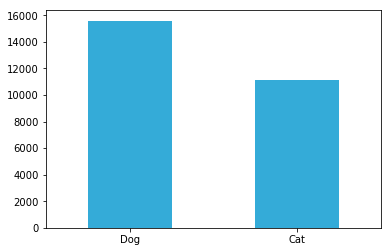

In [101]:
#A quick look at the variables

#Animal types
animal_type = data['AnimalType'].value_counts() 
animal_type.plot(kind='bar',color='#34ABD8',rot=0)

In [127]:
#Animal types
p = Bar(data_dog, label='OutcomeType', values = 'TopBreed', agg='count', stack='TopBreed',
        title="Outcomes by Top Breeds", legend='top_right')
show(p)

In [102]:
#Animal types
p = Bar(data, label='OutcomeType', values = 'AnimalType', agg='count', stack='AnimalType',
        title="Outcomes by Animal Type", legend='top_right')
show(p)

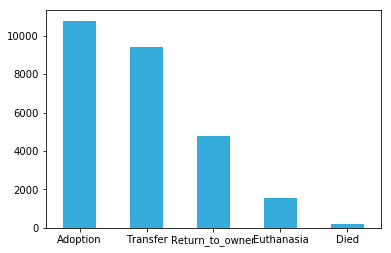

In [103]:
#Outcome types
outcome_type = data['OutcomeType'].value_counts() 
outcome_type.plot(kind='bar',color='#34ABD8',rot=0)

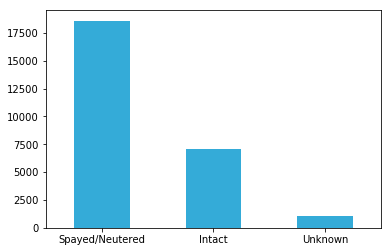

In [104]:
#Spayed/neutered
intact_type = data['Intact'].value_counts() 
intact_type.plot(kind='bar',color='#34ABD8',rot=0)

In [105]:
p = Bar(data, label='OutcomeType', values = 'Intact', agg='count', stack='Intact',
        title="Outcomes by Intact Status", legend='top_right')
show(p)

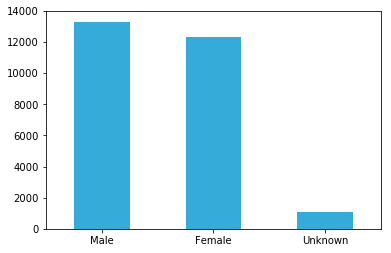

In [106]:
#Sex
intact_type = data['Female'].value_counts() 
intact_type.plot(kind='bar',color='#34ABD8',rot=0)

In [107]:
p = Bar(data, label='OutcomeType', values = 'Female', agg='count', stack='Female',
        title="Outcomes by Female", legend='top_right')
show(p)

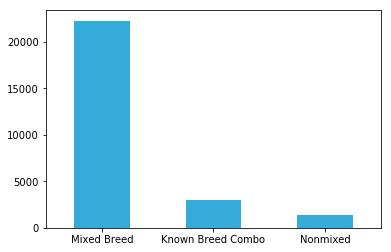

In [108]:
#Purebred/mixed

mixed_breed = data['MixedBreed'].value_counts() 
mixed_breed.plot(kind='bar',color='#34ABD8',rot=0)

In [109]:
p = Bar(data, label='OutcomeType', values = 'MixedBreed', agg='count', stack='MixedBreed',
        title="Outcomes by Breed Type", legend='top_right')
show(p)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000F4DA390>]], dtype=object)

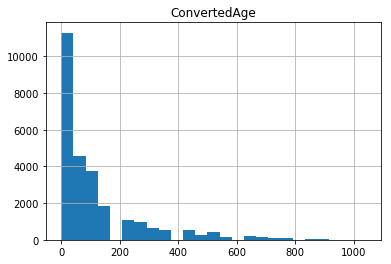

In [110]:
data.hist(column="ConvertedAge", bins=25)

In [111]:
p = Bar(data, label='OutcomeType', values = 'ConvertedAge', agg='mean',
        title="Outcomes by Age", legend='top_right')
show(p)

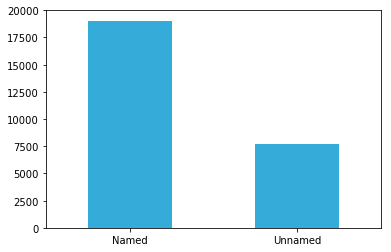

In [112]:
#Named/unnamed

name = data['Named'].value_counts() 
name.plot(kind='bar',color='#34ABD8',rot=0)

In [113]:
p = Bar(data, label='OutcomeType', values = 'Named', agg='count', stack='Named',
        title="Outcomes by Name Status", legend='top_right')
show(p)

In [114]:
OrderedColor = data.OrderedColor.unique()
print("Unique Colors" , (data.OrderedColor.value_counts() > 0).sum())
print(OrderedColor)

('Unique Colors', 275)
['Brown White' 'Cream-Tabby' 'Blue White' 'Blue-Cream' 'Tan' 'Black Tan'
 'Blue-Tabby' 'Brown-Tabby' 'Red White' 'White' 'Black' 'Silver' 'Brown'
 'Black Red' 'Cream White' 'Orange-Tabby White' 'Black White'
 'Brown-Brindle White' 'Black Brown' 'Orange-Tabby' 'Chocolate White'
 'Tan White' 'Cream-Tabby White' 'Blue' 'Calico' 'Torbie' 'Yellow'
 'Tricolor' 'Tortie' 'Blue-Tabby White' 'Gray White' 'Buff'
 'Brown-Tabby White' 'Red' 'Blue Tan' 'Seal-Point' 'Brown-Brindle' 'Gray'
 'White Yellow-Brindle' 'Fawn White' 'Flame-Point' 'Black-Tabby White'
 'Calico Tortie' 'Black Brown-Brindle' 'Silver Tan' 'Black Red-Tick'
 'Blue-Merle' 'Chocolate Tan' 'Sable' 'Brown-Merle White'
 'Brown-Tiger White' 'Liver White' 'Black Gray' 'Cream' 'Chocolate'
 'Blue-Point' 'Apricot White' 'Black Red-Merle' 'Blue-Merle White' 'Fawn'
 'Lynx-Point White' 'Black Fawn' 'Red-Tick White' 'Buff Tan'
 'Brown-Brindle Red-Tick' 'Lilac-Point' 'Buff White' 'Tortie-Point'
 'Lynx-Point' 'Tortie White' 

In [115]:
OrderedBreed = data.OrderedBreed.unique()
print("Unique Breeds" , (data.OrderedBreed.value_counts() > 0).sum())
print(OrderedBreed)

('Unique Breeds', 1143)
['Shetland-Sheepdog-Mix' 'Domestic-Shorthair-Mix' 'Pit-Bull-Mix' ...,
 'English-Bulldog French-Bulldog' 'Boxer Vizsla'
 'Australian-Kelpie German-Shepherd']


In [116]:
def main():
    print "Number of observations: ", len(data.index)
    print "Number of columns: ", len(data.columns)
    print "Headers: ", data.columns.values

if __name__ == "__main__":
    main()



Number of observations:  26729
Number of columns:  19
Headers:  ['AnimalID' 'Name' 'DateTime' 'OutcomeType' 'OutcomeSubtype' 'AnimalType'
 'SexuponOutcome' 'AgeuponOutcome' 'Breed' 'Color' 'Female' 'ConvertedAge'
 'Intact' 'MixedBreed' 'TopBreed' 'BreedRank' 'Named' 'OrderedColor'
 'OrderedBreed']


### LOGISTIC REGRESSION

In [117]:
print X_train.shape
print X_dev.shape
print y_train.shape
print y_dev.shape

(20046, 8)
(6683, 8)
(20046, 1)
(6683, 1)
